# Estimating the global demand curve for a leishmaniasis vaccine: a generalisable approach based on global burden of disease estimates 

This jupyter notebook generates the figures included in the above paper. The input file is leish vaccine_demand curve analysis_FINAL.xlsx available on GitHub - https://github.com/sakshimohan/leish-vaccine/blob/main/leish%20vaccine_demand%20curve%20analysis_FINAL.xlsx

In [1]:
import pandas as pd
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D # for manually adding legends
import math
import os.path
import os
import numpy as np
import seaborn as sb
import copy

# 1. Load and prepare data

In [2]:
path = 'C:/Users/sm2511/Dropbox/York/Research Projects/Leishmaniasis vaccine/1 - Report and Tool/'
os.chdir(path)
os.getcwd()

# Load the latest version of the leishmaniasis demand curve analysis workbook
wb = load_workbook('leish vaccine_demand curve analysis_FINAL.xlsx', data_only=True)
datasheet= wb['demand_curve']

C:\Users\sm2511\anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [3]:
# Create dataframe
df = pd.DataFrame(datasheet.values)
df.columns = df.iloc[2]
df = df.drop([0,1,2])
df.drop(df.columns[0], axis=1, inplace=True)
df = df[0:24]

In [4]:
# Full list of pricing scenarios considered
scenarios = ['price_gavi_notreat', 'price_gavi_treat',
                        'price_nogavi_notreat', 'price_nogavi_treat',
                        'price_nogavi_notreat_low', 'price_nogavi_treat_low', 
                        'price_nogavi_notreat_high', 'price_nogavi_treat_high',
                        'price_gavi_notreat_low', 'price_gavi_treat_low', 
                        'price_gavi_notreat_high', 'price_gavi_treat_high',
                        'price_nogavi_notreat_loweff', 'price_nogavi_treat_loweff', 
                        'price_nogavi_notreat_higheff', 'price_nogavi_treat_higheff',
                        'price_underreport_notreat_low', 'price_underreport_treat_low',
                        'price_underreport_notreat_high', 'price_underreport_treat_high']
# Create dataframe with all pricing scenarios
full_ddcurve_data = df[scenarios]
full_ddcurve_data = pd.concat([df[['country','demand']], full_ddcurve_data], axis=1) 

# Generate columns denoting cumulative demand for all pricing scenarios
for scenario in scenarios:
    # Arrange in descending order of price
    full_ddcurve_data.sort_values([scenario], ascending=[False],inplace=True)
    # Calculate cumulative demand
    varname = 'cumdemand' + scenario[5:]
    print(varname, " generated")
    full_ddcurve_data[varname] = full_ddcurve_data['demand'].cumsum()

full_ddcurve_data.sort_values(['country'], ascending=[True],inplace=True)
# full_ddcurve_data.columns

cumdemand_gavi_notreat  generated
cumdemand_gavi_treat  generated
cumdemand_nogavi_notreat  generated
cumdemand_nogavi_treat  generated
cumdemand_nogavi_notreat_low  generated
cumdemand_nogavi_treat_low  generated
cumdemand_nogavi_notreat_high  generated
cumdemand_nogavi_treat_high  generated
cumdemand_gavi_notreat_low  generated
cumdemand_gavi_treat_low  generated
cumdemand_gavi_notreat_high  generated
cumdemand_gavi_treat_high  generated
cumdemand_nogavi_notreat_loweff  generated
cumdemand_nogavi_treat_loweff  generated
cumdemand_nogavi_notreat_higheff  generated
cumdemand_nogavi_treat_higheff  generated
cumdemand_underreport_notreat_low  generated
cumdemand_underreport_treat_low  generated
cumdemand_underreport_notreat_high  generated
cumdemand_underreport_treat_high  generated


# 2. Generate figures for paper
## 2.1 Define necessary functions

In [12]:
# Define a function to plot demand curves for the primary scenario

def dd_brokengraph_main(title, mainylim, outlierylim, mainytick_gap, outlierytick_gap, breakgap, scenario, treat_scen, name, labels):

    # Create a new figure with two subplots
    fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True)

    # Set the y-limits on each subplot
    ax1.set_ylim(mainylim+9,outlierylim)
    ax2.set_ylim(0,mainylim)
    ax2.set_xlim(0,600)
    ax1.set_xlim(0,600)

    # Set x and y tick marks for both plots
    upper_yticks = np.arange(mainylim+breakgap,outlierylim,outlierytick_gap) # Upper plot
    ax1.set_yticks(upper_yticks)
    
    lower_yticks =np.arange(0,mainylim + 1 ,mainytick_gap) # Lower plot
    ax2.set_yticks(lower_yticks)
    
    x_ticks = np.arange(0,600,50)
    ax1.set_xticks(x_ticks)
    ax2.set_xticks(x_ticks) 

    # Plot demand data (under 3 remdex availability scenarios) into each subplot
    grh_color = ['red','green', 'black']
    line_style = ['dotted', 'dotted', 'solid'] 
    c = 0
    
    for eff_scen in ['_low','_high', '']:   
        price = 'price_' + scenario  + treat_scen + eff_scen
        cumdemand = 'cumdemand_' + scenario  + treat_scen + eff_scen
        full_ddcurve_data.sort_values([price], ascending=[False],inplace=True)
        ax1.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
        ax2.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
        c += 1 
        
    ## Improve the appearence so that the the subplots look like one graph
    # Remove the bottom border from the top plot and the upper border from the bottom plot
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # Show only top x-axis tick marks on the top plot
    ax1.xaxis.tick_top() 
        #ax1.tick_params(labeltop='off') # hides the labels from the top x-axis
    # Show only bottom x-axis tick marks on the lower plot
    ax2.xaxis.tick_bottom()
    # Squeeze plots closer
    plt.subplots_adjust(hspace=0.05) #set to zero, if you want to join the two plots
    
    # EMBELLISHMENTS
    # Add diagonal lines to represent the kink in the y-graph
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # LABELS AND LEGENDS
    # Create legend labels common across graphs
    colors = ['red','green','black']
    line_style = ['dotted', 'dotted', 'solid'] 
    lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=line_style[c]) for c in [0,1,2]]
    labels = labels

    ax1.set_title(title, y=-1.8)
    #ax1.legend(handles=[green_patch, blue_patch, red_patch])
    ax1.legend(lines, labels, fontsize=11)
    ax2.set_xlabel('Demand for leishmaniasis vaccine courses, 2030-2040 (millions)')
    ax1.set_ylabel('Price (2019 USD)')
    plt.savefig(name, dpi = 300)

In [6]:
# Define a function to plot demand curves for the Gavi scenario

def dd_brokengraph_gavi(title, mainylim, outlierylim, mainytick_gap, outlierytick_gap, breakgap, scenario, treat_scen, name, labels):

    # Create a new figure with two subplots
    fig,(ax1,ax2) = plt.subplots(2, 1, sharex=True)

    # Set the y-limits on each subplot
    ax1.set_ylim(mainylim+9,outlierylim)
    ax2.set_ylim(0,mainylim)
    ax2.set_xlim(0,600)
    ax1.set_xlim(0,600)

    # Set x and y tick marks for both plots
    upper_yticks = np.arange(mainylim+breakgap,outlierylim,outlierytick_gap) # Upper plot
    ax1.set_yticks(upper_yticks)
    
    lower_yticks =np.arange(0,mainylim + 1 ,mainytick_gap) # Lower plot
    ax2.set_yticks(lower_yticks)
    
    x_ticks = np.arange(0,600,50)
    ax1.set_xticks(x_ticks)
    ax2.set_xticks(x_ticks) 

    # Plot demand data (under 3 remdex availability scenarios) into each subplot
    grh_color = ['red','green', 'blue', 'black']
    line_style = ['dotted', 'dotted', 'solid', 'dotted'] 
    c = 0
    
    for eff_scen in ['_low','_high', '']:   
        price = 'price_' + scenario  + treat_scen + eff_scen
        cumdemand = 'cumdemand_' + scenario  + treat_scen + eff_scen
        full_ddcurve_data.sort_values([price], ascending=[False],inplace=True)
        ax1.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
        ax2.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
        c += 1 
    
    price = 'price_' + 'nogavi_'  + treat_scen + eff_scen
    cumdemand = 'cumdemand_' + 'nogavi_'  + treat_scen + eff_scen
    full_ddcurve_data.sort_values([price], ascending=[False],inplace=True)
    ax1.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
    ax2.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])

    ## Improve the appearence so that the the subplots look like one graph
    # Remove the bottom border from the top plot and the upper border from the bottom plot
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    # Show only top x-axis tick marks on the top plot
    ax1.xaxis.tick_top() 
        #ax1.tick_params(labeltop='off') # hides the labels from the top x-axis
    # Show only bottom x-axis tick marks on the lower plot
    ax2.xaxis.tick_bottom()
    # Squeeze plots closer
    plt.subplots_adjust(hspace=0.05) #set to zero, if you want to join the two plots
    
    # EMBELLISHMENTS
    # Add diagonal lines to represent the kink in the y-graph
    d = .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # LABELS AND LEGENDS
    # Create legend labels common across graphs
    colors = ['red','green','blue', 'black']
    line_style = ['dotted', 'dotted', 'solid', 'dotted'] 
    lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=line_style[c]) for c in [0,1,2,3]]
    labels = labels

    ax1.set_title(title, y=-1.8)
    #ax1.legend(handles=[green_patch, blue_patch, red_patch])
    ax1.legend(lines, labels, fontsize=11)
    ax2.set_xlabel('Demand for leishmaniasis vaccine courses, 2030-2040 (millions)')
    ax1.set_ylabel('Price (2019 USD)')
    plt.savefig(name, dpi = 300)

## 2.2 Use function to generate figures
### 2.2.1 Figure 1 (Primary Scenario)

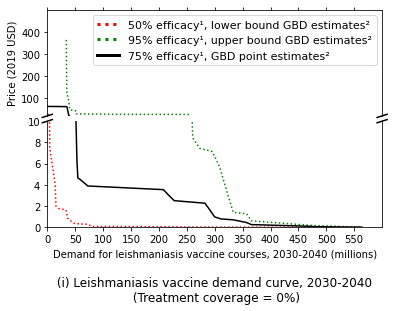

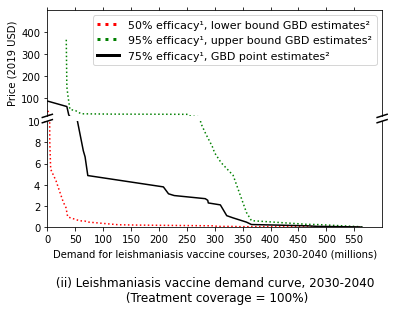

In [7]:
labels = ['50% efficacy\u00B9, lower bound GBD estimates\u00b2', '95% efficacy\u00B9, upper bound GBD estimates\u00b2', '75% efficacy\u00B9, GBD point estimates\u00b2']

chosentitle = '\n (i) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 0%)'
dd_brokengraph_main(title = chosentitle,mainylim = 10 , outlierylim = 500, mainytick_gap = 2, outlierytick_gap = 100, breakgap = 90, 
               scenario = 'nogavi_', treat_scen = 'notreat', name = 'main_notreat.png', labels = labels)
chosentitle = '\n (ii) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 100%)'
dd_brokengraph_main(title = chosentitle,mainylim = 10 , outlierylim = 500, mainytick_gap = 2, outlierytick_gap = 100, breakgap = 90, 
               scenario = 'nogavi_', treat_scen = 'treat', name = 'main_treat.png', labels = labels)


### 2.2.2 Figure 2 (Sensitivity to GAVI contribution)

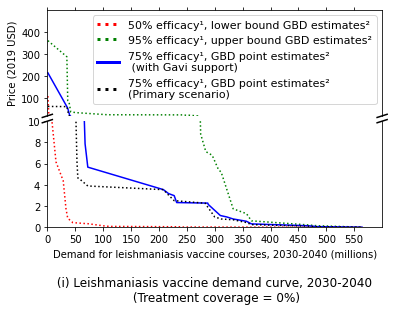

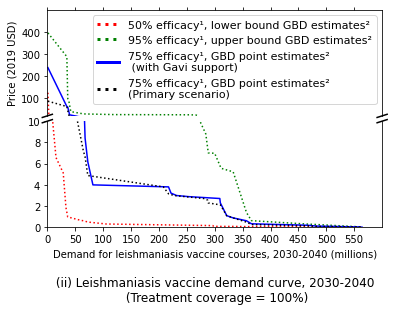

In [8]:
labels = ['50% efficacy\u00B9, lower bound GBD estimates\u00b2', '95% efficacy\u00B9, upper bound GBD estimates\u00b2', 
          '75% efficacy\u00B9, GBD point estimates\u00b2 \n (with Gavi support)', '75% efficacy\u00B9, GBD point estimates\u00b2 \n(Primary scenario)']

chosentitle = '\n (i) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 0%)'
dd_brokengraph_gavi(title = chosentitle,mainylim = 10 , outlierylim = 500, mainytick_gap = 2, outlierytick_gap = 100, breakgap = 90, 
               scenario = 'gavi_', treat_scen = 'notreat', name = 'gavi_notreat.png', labels = labels)
chosentitle = '\n (ii) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 100%)'
dd_brokengraph_gavi(title = chosentitle,mainylim = 10 , outlierylim = 500, mainytick_gap = 2, outlierytick_gap = 100, breakgap = 90, 
               scenario = 'gavi_', treat_scen = 'treat', name = 'gavi_treat.png', labels = labels)


### 2.2.3 Figure 3 (Sensitivity to underreporting)

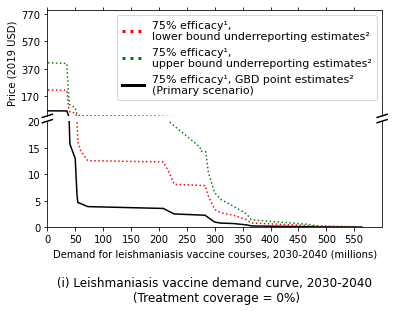

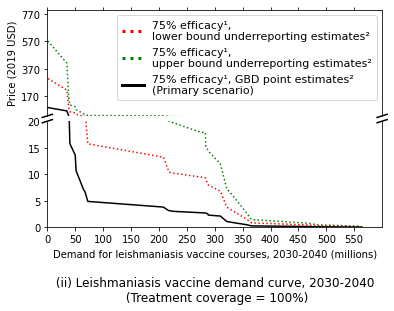

In [13]:
labels = ['75% efficacy\u00B9, \nlower bound underreporting estimates\u00b2', '75% efficacy\u00B9, \nupper bound underreporting estimates\u00b2', '75% efficacy\u00B9, GBD point estimates\u00b2 \n(Primary scenario)']

full_ddcurve_data['price_underreport_notreat'] = full_ddcurve_data['price_nogavi_notreat']
full_ddcurve_data['cumdemand_underreport_notreat'] = full_ddcurve_data['cumdemand_nogavi_notreat']
full_ddcurve_data['price_underreport_treat'] = full_ddcurve_data['price_nogavi_treat']
full_ddcurve_data['cumdemand_underreport_treat'] = full_ddcurve_data['cumdemand_nogavi_treat']

chosentitle = '\n (i) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 0%)'
dd_brokengraph_main(title = chosentitle,mainylim = 20 , outlierylim = 800, mainytick_gap = 5, outlierytick_gap = 200, breakgap = 150, 
               scenario = '', treat_scen = 'underreport_notreat', name = 'underreport_notreat.png', labels = labels)
chosentitle = '\n (ii) Leishmaniasis vaccine demand curve, 2030-2040 \n (Treatment coverage = 100%)'
dd_brokengraph_main(title = chosentitle,mainylim = 20 , outlierylim = 800, mainytick_gap = 5, outlierytick_gap = 200, breakgap = 150, 
               scenario = '', treat_scen = 'underreport_treat', name = 'underreport_treat.png', labels = labels)

### 2.2.4 Additional figure to demonstrate why the y-axis was cut

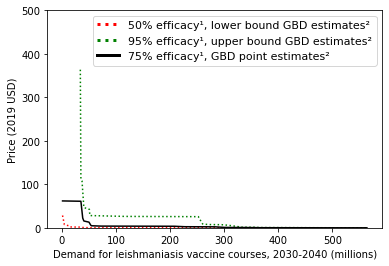

In [198]:
# Create a new figure with two subplots
fig,ax = plt.subplots(1, 1, sharex=True)

grh_color = ['red', 'green', 'black']
line_style = ['dotted', 'dotted', 'solid'] 
scenario = 'nogavi'
treat_scen = 'notreat'
c = 0

for eff_scen in ['_low','_high', '']:   
    price = 'price_' + scenario + '_' + treat_scen + eff_scen
    cumdemand = 'cumdemand_' + scenario + '_' + treat_scen + eff_scen
    full_ddcurve_data.sort_values([price], ascending=[False],inplace=True)
    ax.plot(full_ddcurve_data[cumdemand]/1000000,full_ddcurve_data[price], color = grh_color[c], linestyle = line_style[c])
    c += 1 

# Legend
labels = ['50% efficacy\u00B9, lower bound GBD estimates\u00b2', '95% efficacy\u00B9, upper bound GBD estimates\u00b2', '75% efficacy\u00B9, GBD point estimates\u00b2']
colors = ['red','green','black']
line_style = ['dotted', 'dotted', 'solid'] 
lines = [Line2D([0], [0], color=colors[c], linewidth=3, linestyle=line_style[c]) for c in [0,1,2]]
labels = labels

ax.set_ylim(0,500)
ax.legend(lines, labels, fontsize=11)
ax.set_xlabel('Demand for leishmaniasis vaccine courses, 2030-2040 (millions)')
ax.set_ylabel('Price (2019 USD)')
plt.savefig('main_responses.png')